# CS105 Final Project: Using Text Analysis on Movie Scripts to Predict Genre
### By: Tran Nguyen, Nina Shenoy, Carlos Miranda, Kathleen Dario

Our project idea stemmed from our collective love of movies. After learning about different machine learning + classification techniques in class, we questioned whether we could apply these concepts to movie scripts, and see if we could correctly predict the genre of a movie based on the words in it's script. The techniques we will use are tf-idf, KNN, and cosine similarity.

In [1]:
#Necessary imports for plotting, pandas, math operations, and multiple print statements.
import pandas as pd
from scipy.stats import chi2, chi2_contingency
from IPython.display import Image
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 2. Data Collection & Data Cleaning
#### (Carlos Miranda + Nina Shenoy + Tran Ngueyn + Kathleen Dario)

We retrieved our data from 2 sources: IMDb and Kaggle. The IMDB datasets were used to obtain information about the movies title, genre(s), release date, language, etc. while the Kaggle dataset was used to retrieve the movie scripts. We used inner joins to combine the 3 datasets together, using the IMDB ID as the joining factor.

After combining our datasets, we then had to filter out any unneeded entries.  The IMDb datasets contained tens of thousands of movie entries, dating as far back to the 1800's. We decided that for this project, we will only use feature-length films (excludinv tv series, short-films, etc) that were released in the years (1960-2021) that are in English, and are from the regions of US and Canada. This signifigantly reduced the size of our original dataset, which made runtime faster and easier for us to analyze.

We also noticed that some movies had more than one entry. This was because there were instances where two scripts would correspond to a particular movie. To resolve this, we got rid of the longer script, as it contained unnecessary data such as exposition, cues, and character names, and we mainly wanted to focus on dialogue.

In [2]:
# def removeDuplicates(scripts_basics_df):
#     # Key = IMDB ID , Value = Size of script
#     smallestMovieScriptMap = {}
#     # Key = IMDB ID , Value = index
#     keepIndexMap = {}

#     #show all columns
#     scripts_basics_df.dtypes

#     scripts_basics_df['Scripts'] = scripts_basics_df['Scripts'].apply(str)

#     for index, row in scripts_basics_df.iterrows():
#         constID = row['IMDB ID']
#         currentSize = len(row['Scripts'])

#         if constID in smallestMovieScriptMap:
#             smallestSize = smallestMovieScriptMap[constID]
#             if currentSize < smallestSize:
#                 smallestMovieScriptMap[constID] = currentSize
#                 keepIndexMap[constID] = index
#         else:
#             smallestMovieScriptMap[constID] = currentSize
#             keepIndexMap[constID] = index
#     # keep this removed, this removes first instance
#     # scripts_basics_df = scripts_basics_df[~scripts_basics_df.index.duplicated(keep='first')]
#     return scripts_basics_df[scripts_basics_df.index.isin(keepIndexMap.values())]

In [3]:
# #Read basics.tsv
# basics_df = pd.read_csv("datasets/basics.tsv", sep="\t")

# #Filter basics_df
# basics_df = basics_df[basics_df["titleType"] == "movie"]
# basics_df = basics_df[basics_df["genres"] != "\\N"]
# # basics_df = basics_df[basics_df["startYear"] != "\\N"]
# # basics_df["startYear"] = basics_df["startYear"].apply(int)
# # basics_df = basics_df[basics_df["startYear"] >= 1960]
# basics_df = basics_df.set_index("tconst")

# #Filter akas_df
# akas_df = pd.read_csv("datasets/akas.tsv", sep="\t", dtype={
#     "titleId": "string", 
#     "ordering": int, 
#     "title": "string", 
#     "region":"string",
#     "language":"string"
# })

# akas_df = akas_df[akas_df["region"].isin(["US","CA"])]
# akas_df = akas_df[akas_df["language"] == "en"]
# akas_df = akas_df.set_index("titleId")

# #Join
# akas_basics_df = basics_df.join(akas_df, how='inner')


In [4]:
# #Read scripts.csv
# scripts_df = pd.read_csv("datasets/scripts.csv", dtype={
#     "IMDB ID": "string", 
#     "Scripts": "string", 
#     "release year": int, 
# });
# scripts_df = scripts_df.set_index("IMDB ID");
# scripts_df = scripts_df.drop(['genres'], axis=1)

# scripts_basics_df = akas_basics_df.join(scripts_df, how='inner')
# scripts_basics_df=scripts_basics_df.reset_index()
# scripts_basics_df = scripts_basics_df.rename(columns={'index': 'IMDB ID'})
# scripts_basics_df = removeDuplicates(scripts_basics_df)

In [5]:
#Read clean.csv, which has our cleaned dataset
scripts_basics_df = pd.read_csv("datasets/clean.csv")
scripts_basics_df.head()

,Unnamed: 0,IMDB ID,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,...,language,types,attributes,isOriginalTitle,Unnamed: 0.1,actors,characters,movie title,release year,Scripts
0,0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118,"Comedy,Fantasy,Romance",...,en,imdbDisplay,\N,0,3216,Hugh Jackman,Leopold,Kate & Leopold,2001,"Time. Time, it has been proposed is the fourth..."
1,2,tt0101004,movie,Zandalee,Zandalee,0,1991,\N,100,"Drama,Romance,Thriller",...,en,imdbDisplay,\N,0,1582,Nicolas Cage,Johnny Collins,Zandalee,1991,NaN
2,3,tt0101393,movie,Backdraft,Backdraft,0,1991,\N,137,"Action,Crime,Drama",...,en,imdbDisplay,\N,0,78,Robert DeNiro,Donald Rimgale,Backdraft,1991,<font color=orange>© <font color=orange>© P <f...
3,5,tt0101410,movie,Barton Fink,Barton Fink,0,1991,\N,116,"Comedy,Drama,Thriller",...,en,imdbDisplay,\N,0,2066,Frances McDormand,Stage Actress (voice),Barton Fink,1991,Kissing it all good-bye. These four stinkin' w...
4,6,tt0101452,movie,Bill & Ted's Bogus Journey,Bill & Ted's Bogus Journey,0,1991,\N,93,"Adventure,Comedy,Fantasy",...,en,imdbDisplay,\N,0,3255,Keanu Reeves,Ted Logan,Bill & Ted's Bogus Journey,1991,[SUSPENSEFUL MUSIC PLAYING] It is time. They'v...


Since some movies were classified as having multiple genres, we ended up splitting them into multiple entries in our data set, with each entry having one genre. This made it easier for us to calculate the frequencies of the different genres.

In [6]:
scripts_basics_df["genres"] = scripts_basics_df["genres"].str.split(",")
scripts_basics_df = scripts_basics_df.explode("genres")
display(scripts_basics_df[["originalTitle", "Scripts", "genres"]])
display(scripts_basics_df["genres"].unique())

,originalTitle,Scripts,genres
0,Kate & Leopold,"Time. Time, it has been proposed is the fourth...",Comedy
0,Kate & Leopold,"Time. Time, it has been proposed is the fourth...",Fantasy
0,Kate & Leopold,"Time. Time, it has been proposed is the fourth...",Romance
1,Zandalee,NaN,Drama
1,Zandalee,NaN,Romance
...,...,...,...
2143,SPF-18,real life and the movies can get a little mixe...,Romance
2143,SPF-18,real life and the movies can get a little mixe...,Sport
2144,Singularity,Please use left-hand lane. People should be cl...,Action
2144,Singularity,Please use left-hand lane. People should be cl...,Adventure


array(['Comedy', 'Fantasy', 'Romance', 'Drama', 'Thriller', 'Action',
       'Crime', 'Adventure', 'Family', 'Mystery', 'Biography', 'Music',
       'Horror', 'Sci-Fi', 'Animation', 'Sport', 'History', 'Western',
       'War', 'Musical', 'Documentary'], dtype=object)

# NOTE: I was thinking for data cleaning, we could use a quote from a script in our dataset (without cleaning), run our cleaning algo(s) on it, and then show the resulting (clean) quote. This could also be a question for our presentation: What quote did we use to demonstrate how we cleaned our data?

## Exploratory Data Analysis
#### (Nina Shenoy)


### What are the most common film genres in our dataset?

Drama          1205
Comedy          886
Action          623
Crime           502
Romance         426
Adventure       424
Thriller        380
Mystery         203
Fantasy         165
Sci-Fi          156
Biography       112
Animation       107
Family          102
Horror           74
Sport            63
Music            54
History          22
War              22
Western          19
Musical          15
Documentary       2
Name: genres, dtype: int64


<AxesSubplot:>

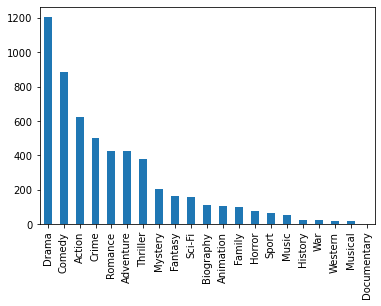

In [7]:
genre_frequency = scripts_basics_df.genres.value_counts()
print(genre_frequency)
genre_frequency.plot.bar()

As we can see per the above bar chart, the majority of the films in the dataset are classified as Drama, Comedy, and/or Action.

### Which genre(s) have the most words?

,originalTitle,Scripts,genres,Length
0,Kate & Leopold,"Time. Time, it has been proposed is the fourth...",Comedy,10862
0,Kate & Leopold,"Time. Time, it has been proposed is the fourth...",Fantasy,10862
0,Kate & Leopold,"Time. Time, it has been proposed is the fourth...",Romance,10862
2,Backdraft,<font color=orange>© <font color=orange>© P <f...,Action,10212
2,Backdraft,<font color=orange>© <font color=orange>© P <f...,Crime,10212
...,...,...,...,...
2143,SPF-18,real life and the movies can get a little mixe...,Romance,8317
2143,SPF-18,real life and the movies can get a little mixe...,Sport,8317
2144,Singularity,Please use left-hand lane. People should be cl...,Action,4103
2144,Singularity,Please use left-hand lane. People should be cl...,Adventure,4103


<AxesSubplot:title={'center':'Length'}, xlabel='genres'>

[Text(0, 0, 'Horror'),
 Text(1, 0, 'Animation'),
 Text(2, 0, 'Adventure'),
 Text(3, 0, 'Thriller'),
 Text(4, 0, 'Action'),
 Text(5, 0, 'Fantasy'),
 Text(6, 0, 'Sci-Fi'),
 Text(7, 0, 'Mystery'),
 Text(8, 0, 'War'),
 Text(9, 0, 'Western'),
 Text(10, 0, 'History'),
 Text(11, 0, 'Family'),
 Text(12, 0, 'Drama'),
 Text(13, 0, 'Crime'),
 Text(14, 0, 'Musical'),
 Text(15, 0, 'Music'),
 Text(16, 0, 'Romance'),
 Text(17, 0, 'Comedy'),
 Text(18, 0, 'Sport'),
 Text(19, 0, 'Biography'),
 Text(20, 0, 'Documentary')]

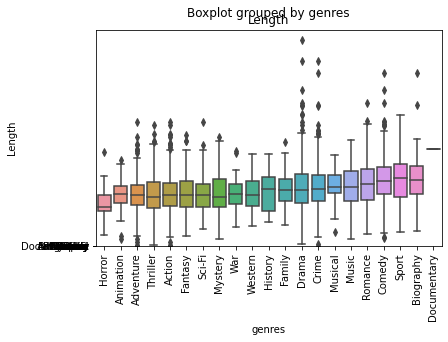

In [8]:
new_df = scripts_basics_df[["originalTitle", "Scripts", "genres"]]
new_df = new_df.dropna() #can be deleted since data should be clean before this step, kept for testing
new_df['Length'] = new_df['Scripts'].str.split(" ").str.len() # adds the length column with length of each script
display(new_df)


# new_df = new_df.groupby("genres")#.plot.box()#.mean() #calculates the avg script length for each genre
# new_df.boxplot()
new_df.boxplot(column='Length',by='genres', vert=False)

grouped = new_df.groupby(['genres']).mean().sort_values(by='Length')

plot_df = sns.boxplot(x=new_df.genres, y=new_df.Length, order=grouped.index)
plot_df.set_xticklabels(plot_df.get_xticklabels(),rotation=90)
# new_df = new_df.sort_values(by=['Length'])
# display(new_df)
# new_df.transpose().plot.box()


# sns.heatmap(new_df, annot=True) #print heatmap
# new_df.plot.box()

### What are the most common words in each genre?

In [9]:
from collections import Counter

# Get script for Jurassic Park (1993) and print!
# Sauce: https://www.geeksforgeeks.org/find-k-frequent-words-data-set-python/
pd.set_option('display.max_colwidth', None)
jp_script = scripts_basics_df.at[118, 'Scripts']

split_it = jp_script.to_string().split()
Counter = Counter(split_it)

most_occur = Counter.most_common(10)
  
print(most_occur)



[('-', 951), ('I', 780), ('the', 612), ('you', 564), ('a', 480), ('to', 417), ('and', 330), ('of', 270), ('that', 261), ('in', 255)]


# Analysis + Techniques
#### (Tran Nguyen)

KNN

Cosine Similarity

tf-idf